In [2]:
#consider putting annotations (both train and val in) s3://sundial-ob-detection/train/input/roof-face-object-detection/config/5k.yaml

In [1]:
import boto3
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'cache_allocated'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'nocompaction'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:516"
import sys
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from dataset_loader import RoofTopImage
from backbone import R2U_Net, NonMaxSuppression, DetectionBranch
from matching import OptimalMatching
from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss,CrossEntropyLoss
from torch.optim import Adam
from torchsummary import summary
import itertools
import gc
import json
import time
from utils import scores_to_permutations,permutations_to_polygons,permutation_mask,angle_between_points
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import losses as ls
from shapely.geometry import Polygon
import rasterio
from shapely.validation import explain_validity
import itertools
import logging
logging.getLogger('shapely.geos').setLevel(logging.CRITICAL)
from skimage import draw
import math
from collections import defaultdict

In [8]:
#s3://sundial-geometric-roof-inference/images/cropped/train/GSUN_00000000_W0995_H0997_+021.31747_-158.01884.tif
#s3://sundial-geometric-roof-inference/images/crowdai/train/000000000000.jpg
#s3://sundial-geometric-roof-inference/images/raw/GSUN_00000000_W0995_H0997_+021.31747_-158.01884.tif
#s3://sundial-geometric-roof-inference/images/val/GSUN_00000000_W1001_H1000_+042.13991_-071.45583.tif

IMAGE_BUCKET="sundial-geometric-roof-inference"

TRAIN_IMAGE_PREFIX= "images/crowdai/train"
VAL_IMAGE_PREFIX= "images/crowdai/val" 


TRAIN_ANNOTATION_PATH = '../gt_annotations/crowdai_train_annotation.json'
VAL_ANNOTATION_PATH = '../gt_annotations/crowdai_val_annotation.json'

PREDICTION_PATH = 'raw_val_predictions.json'

BATCH_SIZE = 6
MAX_CORNER_POINTS = 256
NUM_EPOCHS = 10
INIT_LR = 0.001
LAMBDA = 1000
IMG_SIZE = 320
BASE_OUTPUT = "output"

PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "matching/matching_seg_losse_only_epoch.png"])
TRAINING_OUTPUT = os.path.sep.join([BASE_OUTPUT, 'matching/matching_seg_losse_only_epoch.json'])

MATCHING_MODEL_PATH = os.path.join(BASE_OUTPUT,'matching/', "matching_seg_losse_only_epoch.pth")
#DETECTIONBRANCH_MODEL_PATH = os.path.join(BASE_OUTPUT,'vertex_detection/', "detectionbranch_model_small_crowdai_data.pth")
#BACKBONE_MODEL_PATH = os.path.join(BASE_OUTPUT,'vertex_detection/', "backbone_model_small_crowdai_data.pth")

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
    gc.collect()
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')

torch.autograd.set_detect_anomaly(True) # for debugging purpose

print(MATCHING_MODEL_PATH)
#print(DETECTIONBRANCH_MODEL_PATH)
#print(BACKBONE_MODEL_PATH)
print()
print(TRAINING_OUTPUT)
print(PLOT_PATH)

output/matching/matching_seg_losse_only_epoch.pth

output/matching/matching_seg_losse_only_epoch.json
output/matching/matching_seg_losse_only_epoch.png


In [4]:
cnn_backbone = R2U_Net()
cnn_backbone = cnn_backbone.to(device)
cnn_backbone.train()

conv_one_one = DetectionBranch()
conv_one_one = conv_one_one.to(device)
conv_one_one.train()

#loading backbone network
cnn_backbone.load_state_dict(torch.load('../trained_weights/polyworld_backbone',map_location=device)) #transfer learning
#cnn_backbone.load_state_dict(torch.load("output/vertex_detection/backbone_model_small_crowdai_data.pth",map_location=device))

#loading detection branch
conv_one_one.load_state_dict(torch.load("../trained_weights/polyworld_seg_head",map_location=device)) #transfer learning
#conv_one_one.load_state_dict(torch.load("output/vertex_detection/detectionbranch_model_small_crowdai_data.pth",map_location=device))

suppression = NonMaxSuppression(MAX_CORNER_POINTS)
suppression = suppression.cuda()

matching = OptimalMatching()
matching = matching.to(device)
matching = matching.train()
#matching.load_state_dict(torch.load("../trained_weights/polyworld_matching",map_location=device))
matching.load_state_dict(torch.load("output/scratch/matching_scratch_match_angle_losses_3_epochs.pth",map_location=device))
#matching.load_state_dict(torch.load("output/matching/matching_match_angle_seg_losses_5_epoch.pth",map_location=device))

#freeze the backbone and vertex detection neworks 
for param in cnn_backbone.parameters():
    param.requires_grad = False

for param in conv_one_one.parameters():
    param.requires_grad = False
    
print("{:.3f}MB allocated".format(torch.cuda.memory_allocated()/1024**2))

150.573MB allocated


In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))


train_data = RoofTopImage(IMAGE_BUCKET,
                          TRAIN_IMAGE_PREFIX,
                          TRAIN_ANNOTATION_PATH,
                          MAX_CORNER_POINTS, 
                          IMG_SIZE,
                          BATCH_SIZE,
                          load_type = 'train'
                         )

trainloader = DataLoader(train_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0,
                        pin_memory=False,
                        #prefetch_factor = BATCH_SIZE,
                        drop_last=True,
                        collate_fn=collate_fn
                    )

'''
val_data = RoofTopImage(IMAGE_BUCKET,
                        VAL_IMAGE_PREFIX,
                        VAL_ANNOTATION_PATH,
                        MAX_CORNER_POINTS,
                        IMG_SIZE,
                        BATCH_SIZE,
                        load_type = 'val'
                       )

valloader = DataLoader(val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        pin_memory=False,
                        prefetch_factor = BATCH_SIZE,
                        drop_last=True,
                       collate_fn=collate_fn
                    )
'''

'''
pos_weight = torch.tensor([100]).to(device)
lossFunc = BCEWithLogitsLoss(pos_weight = pos_weight)
params = [cnn_backbone.parameters(), conv_one_one.parameters(),matching.parameters()]
optimizer = Adam(itertools.chain(*params), lr = INIT_LR,weight_decay=0.01)
'''

optimizer = Adam(matching.parameters(), lr = INIT_LR,weight_decay=0.01)

print("{:.3f}MB allocated".format(torch.cuda.memory_allocated()/1024**2))

#calculate steps per epoch for training and test set
trainSteps = len(train_data) // BATCH_SIZE
valSteps = 1#len(val_data) // BATCH_SIZE

print('Training and validation steps {} {}'. format(trainSteps,valSteps))

H= {
    "train_total_loss":[],
    "val_total_loss":[],
    "iterations":[]
    } 
#to keep training history

loading annotations into memory...
Done (t=24.19s)
creating index...
index created!
150.573MB allocated
Training and validation steps 1664 1


In [6]:
def sort_sync_nsm_points(nms_graph, vertices,gt_index): 
    B, N, D= nms_graph.shape #1,256,2
    sorted_nsm_points = np.zeros((B,N,D), dtype=int)
    nms_graph = nms_graph.detach().cpu().numpy()
    
    for b in range(B):
        sorted_nsm = np.zeros((N,D), dtype=int)

        #vertices = np.array([v for polygon in gt_indices[b] for v in polygon[:-1]])        
        n = vertices[b].shape[0]
        m = nms_graph[b].shape[0]
    
        distances = np.linalg.norm(vertices[b][:, None] - nms_graph[b], axis=2)
        distances = distances.reshape(n*m, 1)
        
        distances = np.hstack((distances,np.repeat(vertices[b], m, axis=0),np.tile(nms_graph[b], (n, 1))))
        sorted_distance = distances[np.argsort(distances[:,0])]
        
        # Sort distances by the first column (distance)
        sorted_distances = distances[np.argsort(distances[:,0])]

        cndd_used = set()
        gt_used = set()
        cndd_mapped = {tuple(cndd):0 for cndd in nms_graph[b]}
       
        for d_p in sorted_distances:
            gt_p = tuple((d_p[1], d_p[2]))
            cndd_p = tuple((d_p[3], d_p[4]))
            if gt_p not in gt_used and cndd_p not in cndd_used:
                #print('we have a match ..', gt_p ,'->', cndd_p, ' with distance of ', d_p[0])
                sorted_nsm[gt_index[b][gt_p]]= list(cndd_p)
                gt_used.add(gt_p)
                cndd_used.add(cndd_p)
                cndd_mapped[cndd_p] =1
                                
        restart_index = n
        for k, v in cndd_mapped.items():
            if v ==0:
                sorted_nsm[restart_index] = list(k)   
                restart_index +=1
        sorted_nsm_points[b] = sorted_nsm 
    return torch.from_numpy(sorted_nsm_points).to(device)

def prepare_gt_vertices(vertices):
    B = len(vertices)
    v_gt = torch.empty((BATCH_SIZE,MAX_CORNER_POINTS,2), dtype=torch.float64)
    for b in range(B):
        gt_size = vertices[b].shape[0]
        extra = torch.full((MAX_CORNER_POINTS-gt_size,2),0, dtype = torch.float64)
        extra_gt = torch.cat((torch.from_numpy(vertices[b]), extra), dim=0).to(device)
        v_gt[b] = extra_gt
    return v_gt.to(device)

def compute_l_angle_loss(gt_permutation_mask, 
                         vertices,
                         pred_permutation_mat, 
                         graph):
    v_gt = prepare_gt_vertices(vertices)

    v_gt_1 = torch.matmul(gt_permutation_mask, v_gt)
    v_gt_2 = torch.matmul(gt_permutation_mask, v_gt_1)
    gt_angle = angle_between_points(v_gt, v_gt_1, v_gt_2)
    #torch.isnan(gt_angle).any()
    
    pred_permutation_mat = pred_permutation_mat.to(device)
    v_pred_1 = torch.matmul(pred_permutation_mat,graph)
    v_pred_2 = torch.matmul(pred_permutation_mat,v_pred_1)
    pred_angle = angle_between_points(graph, v_pred_1, v_pred_2)
    #torch.isnan(pred_angle).any()
    
    return pred_angle, gt_angle


def soft_winding_number(pred_polys, lam=LAMBDA):
    B = len(pred_polys)
    pred_mask = torch.zeros((B,IMG_SIZE,IMG_SIZE)).to(device) #
    
    x = torch.arange(IMG_SIZE)
    y = torch.arange(IMG_SIZE)
    xx, yy = torch.meshgrid(x,y)

    pixel_coords = torch.stack([yy, xx], dim=-1).float()
    
    for b in range(B):
        # get det     
        vertices  = torch.vstack(pred_polys[b]).float()
        #vertices = vertices.detach().cpu()
        #vertices.requires_grad=True
        #vertices =  vertices.unfold(dimension = 0,size = 2, step = 1)
        #vertices_repeated = vertices.repeat_interleave(IMG_SIZE*IMG_SIZE, dim=0)
        
        pairs = vertices[:-1].unsqueeze(1).repeat(1, 2, 1)
        pairs[:, 1, :] = vertices[1:]
        
        pairs_repeated = pairs.repeat_interleave(IMG_SIZE*IMG_SIZE, dim=0)
        
        #pixel_coords_angle = pixel_coords.repeat(vertices.shape[0],1,1).view(vertices.shape[0] *IMG_SIZE*IMG_SIZE,2)
        #pixel_coords_det = pixel_coords.repeat(vertices.shape[0],1,1).view(vertices.shape[0] *IMG_SIZE*IMG_SIZE ,2,1)
        pixel_coords_angle = pixel_coords.repeat(pairs.shape[0],1,1).view(pairs.shape[0] *IMG_SIZE*IMG_SIZE ,1,2).to(device)
        
        concatenated = torch.cat([pairs_repeated, pixel_coords_angle], dim=1)
        
        #ones = torch.ones(IMG_SIZE*IMG_SIZE*vertices.shape[0], 3).reshape(IMG_SIZE*IMG_SIZE*vertices.shape[0],1, 3)
        
        ones = torch.ones(pairs.shape[0] *IMG_SIZE*IMG_SIZE, 3, 1).to(device)#.reshape(vertices.shape[0]-1 *IMG_SIZE*IMG_SIZE,3, 1)
        output = torch.cat((concatenated, ones), dim=2)

        det = torch.det(output)

        # compute angle
        angles = angle_between_points(pairs_repeated[:, 0],pixel_coords_angle.view(pairs.shape[0] *IMG_SIZE*IMG_SIZE,2),pairs_repeated[:, 1], batch=False)
       
        #Compute the soft winding number using equation 13
        w = (lam * det) / (1 + torch.abs(det *lam))
        w = w * angles

        w = w.view(pairs.shape[0], IMG_SIZE, IMG_SIZE)
        # Sum over all pairs of adjacent vertices to get the winding number
        w = w.sum(dim=0)
        
        pred_mask[b] = w

    return pred_mask

In [ ]:
c = 0

best_val_loss = sys.float_info.max
torch.cuda.empty_cache()
gc.collect()
startTime = time.time()
origTime = time.time()

'''
image
torch.from_numpy(gt_permutation_matrix) 
np.array(vertices)
gt_index
torch.from_numpy(corner_mask) 
torch.from_numpy(mask)
'''

for e in tqdm(range(NUM_EPOCHS)):
    #matching.train()
    #conv_one_one.train()
    #cnn_backbone.train()

    total_trainloss, totalvalloss =0,0
    found = False
    for i, train_batch in enumerate(trainloader):
        train_image = torch.stack(train_batch[0]).to(device)
        gt_permutation_mask = torch.stack(train_batch[1]).to(device)
        #assert(BATCH_SIZE * 256 == gt_permutation_mask.sum())
        vertices = train_batch[2]
        gt_index = train_batch[3]
        gt_corner_mask = torch.stack(train_batch[4]).to(device)
        target_mask = torch.stack(train_batch[5]).to(device)
       
        feature_map = cnn_backbone(train_image)
        vertex_mask = conv_one_one(feature_map)
  
        _, nms_graph = suppression(vertex_mask)
        sorted_nsm_points=sort_sync_nsm_points(nms_graph, vertices,gt_index)
        
        #sinkhorn_scores,permutation_mat,graph,pred_polys 
        partial_assignment,pred_permutation_mat, graph,pred_polys= matching(IMG_SIZE,IMG_SIZE, feature_map,sorted_nsm_points) 
        
        try:
            pred_mask = soft_winding_number(pred_polys, LAMBDA)
        except:
            print('skipping the {}th iteration'.format(i))
            continue
        
        #l_det
        #l_det = lossFunc(vertex_mask.reshape((BATCH_SIZE,IMG_SIZE,IMG_SIZE)),gt_corner_mask)
        seg_loss = ls.iou_loss(pred_mask, target_mask)
        
        pred_angle, gt_angle = compute_l_angle_loss(gt_permutation_mask, vertices,pred_permutation_mat, graph)
        l_angle = torch.mean(1- torch.exp(-10*torch.abs((pred_angle-gt_angle))))
        
        l_match = ls.cross_entropy_loss(partial_assignment, gt_permutation_mask) 
        
        totalloss =  l_angle + l_match +seg_loss
        
        
        optimizer.zero_grad()
        totalloss.backward()
        optimizer.step()

        #add the loss to the total training loss so far
        total_trainloss += float(totalloss)
        
        if i % 50 == 0:
            print(" Finish the iter : {}, seg_loss = {}, l_match = {}, l_angle= {}".format(i, float(seg_loss), float(l_match), float(l_angle)))
            endTime = time.time()
            print("[INFO] total time taken to train the model at iteration {} is : {:.2f}s".format(i, (endTime - startTime)))
            startTime = endTime
            #H['train_total_loss'].append(float(l_match))
            #H["iterations"].append(i)
        
       
        #del totalloss
        del train_image
        del feature_map
        del vertex_mask
        del nms_graph
      
        del gt_permutation_mask
        del partial_assignment
        del sorted_nsm_points
        del vertices
        del gt_index
        del target_mask
        del pred_permutation_mat
        del graph
        del pred_polys   
        torch.cuda.empty_cache()
  
    '''
    with torch.no_grad():
        # consider putting the models back to cpu 
        matching.eval()
        #conv_one_one.eval()
        #cnn_backbone.eval()
        
        for l, val_batch in enumerate(valloader):
            y = torch.stack(val_batch[0])
            val_gt_permutation_mask = torch.stack(val_batch[1])
            #assert(BATCH_SIZE * 256 == val_gt_permutation_mask.sum())
            #val_vertices = val_batch[2]
            
            #val_gt_corner_mask = torch.stack(val_batch[3]).to(device)
            
            pred_val = cnn_backbone(y)
            vertex_mask_val = conv_one_one(pred_val)
    
            _, val_nms_graph = suppression(vertex_mask_val)
                                                             
            #val_sorted_nsm_points  = sort_sync_nsm_points(val_nms_graph, val_vertices)
            val_partial_assignment= matching(y, pred_val, val_nms_graph)
            
            #l_val_det = lossFunc(vertex_mask_val.reshape((BATCH_SIZE,IMG_SIZE,IMG_SIZE)),val_gt_corner_mask)

            #get L_match equation 11
            l_val_match = ls.cross_entropy_loss(val_partial_assignment, val_gt_permutation_mask)

            totalvalloss +=float(l_val_match) 
            
            del y
            del pred_val
            del vertex_mask_val
            del val_nms_graph
            
            del val_gt_permutation_mask
            del val_partial_assignment
            #del val_vertices
            #del val_sorted_nsm_points
    
    '''
 
    #calculate the average training and validation loss 
    avgTrainLoss = total_trainloss / trainSteps
    #avgValLoss = totalvalloss / valSteps
    
    if best_val_loss > avgTrainLoss:
        print('Got a new best val/tes loss. Saving model ...')
        best_val_loss = avgTrainLoss
        torch.save(matching.state_dict(), MATCHING_MODEL_PATH) 
        #torch.save(conv_one_one.state_dict(), DETECTIONBRANCH_MODEL_PATH)
        #torch.save(cnn_backbone.state_dict(), BACKBONE_MODEL_PATH)
       
    H['train_total_loss'].append(avgTrainLoss)
    #H['val_total_loss'].append(avgValLoss)

    #print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    #print("Train loss: {:.6f}, Test loss: {:.6f}".format(avgTrainLoss, avgValLoss))
    print("Train loss: {:.6f}".format(avgTrainLoss))
    
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - origTime))

with open( TRAINING_OUTPUT, 'w') as f:
    json.dump(H, f)

  0%|          | 0/10 [00:00<?, ?it/s]

 Finish the iter : 0, seg_loss = 5.792859466290561, l_match = 0.45684343576431274, l_angle= 0.9547037133414694
[INFO] total time taken to train the model at iteration 0 is : 5.43s
skipping the 35th iteration
 Finish the iter : 50, seg_loss = 5.90724488505666, l_match = 0.32508859038352966, l_angle= 0.9506269720624914
[INFO] total time taken to train the model at iteration 50 is : 123.96s
skipping the 71th iteration
skipping the 99th iteration
 Finish the iter : 100, seg_loss = 5.869530630969918, l_match = 0.48099708557128906, l_angle= 0.9991700560479078
[INFO] total time taken to train the model at iteration 100 is : 129.11s
skipping the 118th iteration
skipping the 119th iteration
skipping the 122th iteration
 Finish the iter : 150, seg_loss = 5.814221702672636, l_match = 0.45490992069244385, l_angle= 0.9778361955986187
[INFO] total time taken to train the model at iteration 150 is : 125.59s
skipping the 167th iteration
skipping the 170th iteration
skipping the 189th iteration
 Finish

In [48]:
#l = 1
#vertices = np.array([v for polygon in gt_indices[l] for v in polygon[:-1]])
#Polygon(pred_polys[l][0].detach().cpu().numpy())

6

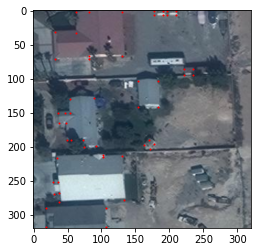

In [19]:
l=4
img = train_image[l].swapaxes(0,1)
img = img.swapaxes(1,2)

plt.grid(False)
plt.imshow(img.detach().cpu())

#plt.imshow(train_image[l][0].detach().cpu().numpy())

black_img = gt_corner_mask[l].detach().cpu()
xs = [i for i in np.where(black_img!=0)[1]]
ys = [i for i in np.where(black_img!=0)[0]]

'''
for i in range(len(xs)):
    st = '('+str(xs[i])+' , '+str(ys[i])+')'
    plt.annotate(st, (xs[i], ys[i] + 2))
'''
plt.scatter(xs,ys, c='red', s= 1)

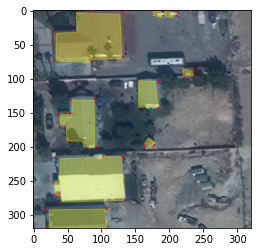

In [20]:
'''
c_y = [i for i in np.where(pressed_img!=0)[0]]
c_x = [i for i in np.where(pressed_img!=0)[1]]
plt.grid(False) 

#plt.scatter(c_x,c_y, s =10, c='black')
#plt.scatter(sorted_nsm_points[l].detach().cpu().numpy()[:,1], sorted_nsm_points[l].detach().cpu().numpy()[:,0],c='red', s= 1)
#plt.scatter(xs,ys, c='red', s= 1)
'''
plt.grid(False)

plt.imshow(img.detach().cpu())

plt.scatter(vertices[l][:,1], vertices[l][:,0],c='red', s= 1)


'''
for i in range(len(xs)):
    st = '('+str(xs[i])+' , '+str(ys[i])+')'
    plt.annotate(st, (xs[i], ys[i] + 2))
plt.show()
'''
n = len(pred_polys[l])
for p in range(n):
    ys,xs = Polygon(pred_polys[l][p].cpu().numpy()).exterior.xy
    plt.fill(xs,ys, alpha = 0.3, color='yellow')
#plt.imshow(target_mass[l].detach().cpu(), cmap ='binary')
plt.show()

In [32]:
#plt.grid(False)
#plt.imshow(black_img)

In [33]:
#plt.grid(False) 
#plt.imshow(vertex_mask[l][0].detach().cpu().numpy())

In [72]:
#plt.grid(False) 
#plt.imshow(torch.sigmoid(vertex_mask[l][0]).detach().cpu().numpy())

(320, 320)


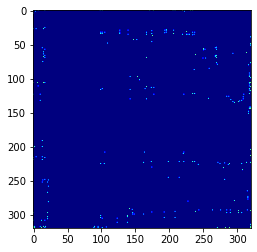

In [15]:
plt.grid(False) 
_, nms_graph = suppression(vertex_mask)
#nms_graph  =torch.flip(nms_graph, dims =[2])
pressed_img = np.zeros_like(vertex_mask[l].detach().cpu().numpy()[0])
print(pressed_img.shape)

for n, m in nms_graph[l].detach().cpu().numpy():
    pressed_img[n,m] = 1

pys = [i for i in np.where(pressed_img!=0)[0]]
pxs = [i for i in np.where(pressed_img!=0)[1]]

plt.imshow(pressed_img, cmap='jet')
#plt.scatter(pxs,pys, s =10, c='black')

In [7]:
#for index, (x,y) in enumerate(zip (vertices[l], sorted_nsm_points[l])):
    #print(index, (x,y))

In [8]:
#for index, (x,y) in enumerate(zip (sorted_nsm_points[l], nms_graph[l])):
   # print(index, (x,y))

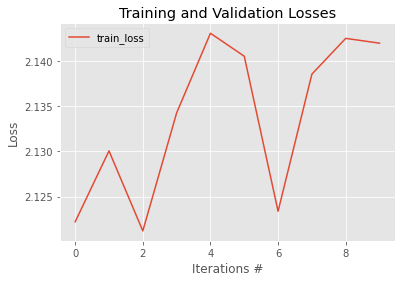

In [20]:
with open(TRAINING_OUTPUT) as f:
    data = json.load(f)

plt.style.use("ggplot")
plt.figure()
plt.plot(data["train_total_loss"], label="train_loss")
#plt.plot(data["val_total_loss"], label="val_loss")
plt.title("Training and Validation Losses")
plt.xlabel("Iterations #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.savefig(PLOT_PATH)   

In [71]:
for idm in img_indx:
    print(idm.item())
    annids = train_coco.getAnnIds(imgIds=idm.item())
    anns = train_coco.loadAnns(annids)
    for ann in anns:
            p = ann['segmentation'][0][:-1]
            point_pair = list(zip(p[::2], p[1::2]))
            print(point_pair)
            print(len(point_pair)-1)
            print()
    Polygon(point_pair)

2959
[(77.00156716876808, 193.9994427223786), (133.15498869177472, 215.75238452414635), (121.00160376833188, 237.99943913168065), (172.99943848908924, 256.9985364537647), (214.99835931897044, 181.00057220796847), (105.0005945024364, 141.00150685485625)]
5

2048
[(259.00117988273183, 231.00110384293785), (260.00117959373426, 261.9987944842246), (305.9988802610714, 260.99890433866466), (304.9988755165542, 231.0012019450906)]
3

[(16.001253185536047, 58.001142152668066), (17.001144462800458, 74.99878623752876), (25.995184726672196, 75.90198285967044), (26.0, 132.95564300192348), (22.000942058143448, 178.00000176828686), (26.001083600847203, 224.99881571469268), (30.995161226716768, 225.8864262224857), (31.001149523978594, 263.9988504760214), (86.99890119315968, 263.99881342344366), (90.7440293123168, 224.77161321046594), (194.1294614130357, 224.36049619272808), (197.0009851162353, 240.99888407784547), (235.97597751097464, 241.0), (235.72689646432954, 224.23750407585368), (286.998855747193

{'id': 319, 'width': 320, 'height': 320, 'file_name': 'GSUN_00000000_W0999_H0998_+033.66778_-112.39685.tif', 'license': 0, 'date_captured': ''}


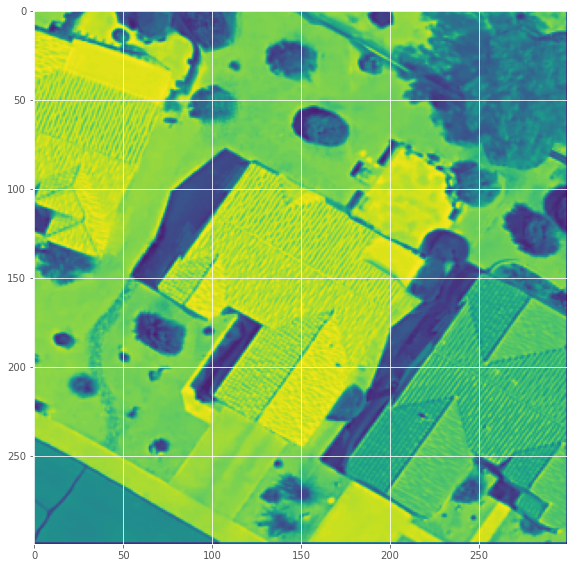

In [212]:
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
img = val_coco.loadImgs(img_indx[l].tolist())[0]
print(img)
raster_img=rasterio.open('../cropped_data/val/'+img['file_name'])
plt.imshow(raster_img.read(1))

array('d', [125.00172778788946, 151.00008839701806, 193.99836614219578, 181.72985085151672, 183.9982119880749, 166.99997437925893, 130.00151254079785, 133.90439300242667, 125.00172778788946])
array('d', [168.00003121489064, 192.99841895764604, 154.99993180440188, 141.7370576607881, 138.99982295192888, 122.0014463548001, 153.00021731893665, 159.54741397522778, 168.00003121489064])


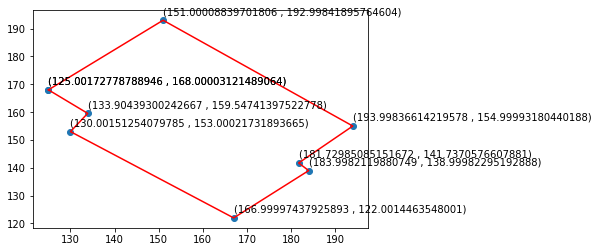

In [176]:
polygon1 = Polygon(point_pair)
x, y = polygon1.exterior.xy
print(x)
print(y)
plt.plot(x, y, c="red")
plt.scatter(x,y)
for i in range(len(x)):
    st = '('+str(x[i])+' , '+str(y[i])+')'
    plt.annotate(st, (x[i], y[i] + 2))
plt.show()

In [9]:
image_s3_path = "s3://{}/{}".format(IMAGE_BUCKET,VAL_IMAGE_PREFIX)
   
raw_data = RoofTopImage(image_s3_path,VAL_ANNOTATION_PATH,250, 320, True, PREDICTION_PATH)
dataloader =  DataLoader(raw_data,
                    batch_size=1,
                    shuffle=True,
                    num_workers=0 #os.cpu_count()
                    )

loading annotations into memory...


OSError: [Errno 9] Bad file descriptor

In [10]:
def plot_image_mask(img, mask):
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    i = 0
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(img[i])
        plt.imshow(mask[i], cmap='jet', alpha=0.4)
        
def validate_gt_permutation(idx):
    p_size = MAX_CORNER_POINTS
    batch = idx.shape[0]
    #gt_perm = np.zeros((batch, p_size, p_size))
    coco = train_data.img_annotations

    for x in idx: # for each image in the batch
        x = x[0].item()
        img = coco.loadImgs(x)[0]
        annids = coco.getAnnIds(imgIds=img['id'])
        anns = coco.loadAnns(annids)
        gt_perm, gt_index = permutation_mask(anns,p_size=MAX_CORNER_POINTS)
        gt_perm[range(list(gt_index.values())[-1]+1,p_size), range(list(gt_index.values())[-1]+1, p_size)] =1
        gt_perm = gt_perm.reshape(1, p_size,p_size)
        
        #print(list(gt_perm.sum(-2)[0]))
        try:
            assert all (v ==1.0 for v in list(gt_perm.sum(-1)[0])) # row sum
        except:
            print(img)
        try:
            assert all (v ==1.0 for v in list(gt_perm.sum(-2)[0])) # column sum 
        except:
            print(img)

In [13]:
iterator = tqdm(valloader)
#_,axs = plt.subplots(2,2,figsize=(15,15))
# create figure
i = 0
gc.collect()
torch.cuda.empty_cache()
for i_batch, sample_batched in enumerate(iterator):

        rgb = sample_batched['image']#.cuda().float()
        idx = sample_batched['image_idx']
        
        
        #print('rgb shape ..', rgb.shape)
        #img = rgb.detach().cpu().numpy()
        #img = img.swapaxes(1,2)
        #img = img.swapaxes(2,3)

        #if i == 0:
            #break
        #i +=0
        validate_gt_permutation(idx)
        
        del rgb
        del idx
        #del gt_mask
        #del img
      
        #gc.collect()
        #torch.cuda.empty_cache()
        if i_batch % 500 == 0:
            print(" Finish checking for iter : {},".format(i_batch))

  1%|          | 1/104 [00:00<01:24,  1.22it/s]

 Finish checking for iter : 0,


100%|██████████| 104/104 [00:12<00:00,  8.21it/s]


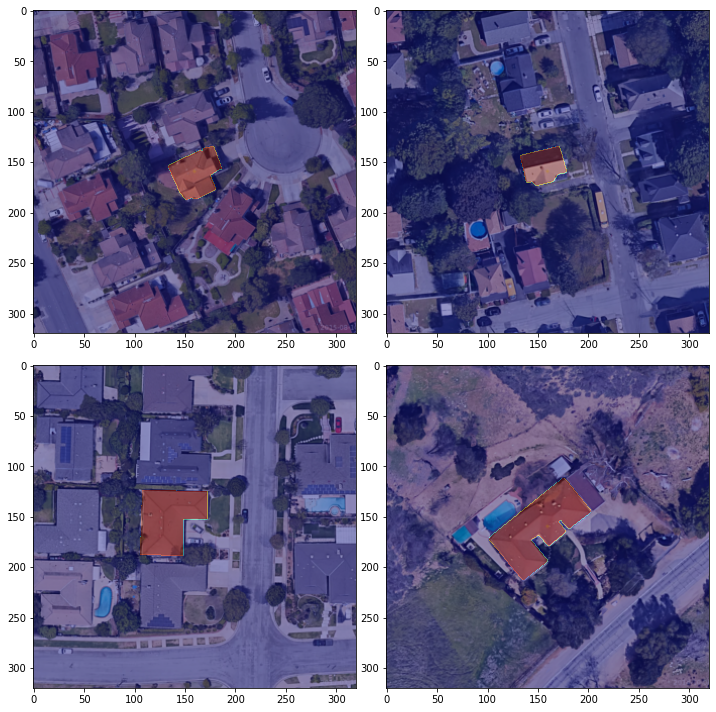

In [289]:
plot_image_mask(img, gt_mask)

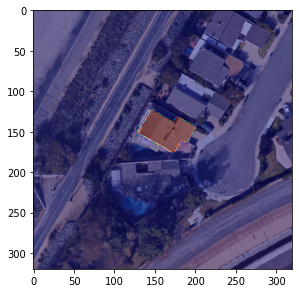

In [186]:

plt.subplot(121)
plt.imshow(img[0])
plt.imshow(gt_mask[0], cmap='jet', alpha=0.4)
#plt.imshow(gt_mask, cmap='binary', alpha=0.4, interpolation ='none')

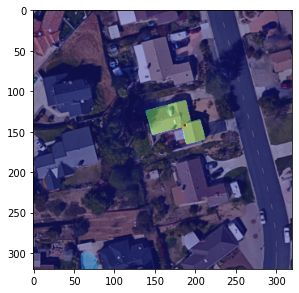

In [182]:
plt.subplot(122)
plt.imshow(img[1])
plt.imshow(gt_mask[1], cmap='jet', alpha=0.4)

In [ ]:
def create_polygon(pp):
    points = [[pp[i*2], pp[i*2+1]] for i in range(len(pp) // 2)]
    return Polygon(points)

def get_pred_polygons(p_polygon):
    pred_polygons = []
    for poly in p_polygon:
        poly = poly.cpu().numpy()
        pp =Polygon(poly) 
        if pp.is_valid:
            pred_polygons.append(pp)
    
    return pred_polygons
        
def get_gt_polygons(idx, coco):
    gt_polygons = []
    
    for im_indx, img_id in enumerate(idx): # for each instance in the batch
        img = coco.loadImgs([img_id.item()])[0]
        annids = coco.getAnnIds(imgIds=img['id'])
        anns = coco.loadAnns(annids)
        for ann in anns:
            gt_points = ann['segmentation'][0]
            pp = create_polygon(gt_points)
            if pp.is_valid:
                gt_polygons.append(pp)
    return gt_polygons

#equation 10
def gt_mask(indx, coco, img_size):

    n = indx.shape[0]
    corner_mask = torch.empty(n, img_size,img_size)
                
    for im_indx, img_id in enumerate(indx): # for each instance in the batch
        img = coco.loadImgs([img_id.item()])[0]
        annids = coco.getAnnIds(imgIds=img['id'])
        anns = coco.loadAnns(annids)
        for indx, ann in enumerate(anns):
            p = ann['segmentation'][0][:-2] # exlucde the last vertex which is similar to the first vertex
            point_pair = list(zip(p[::2], p[1::2]))
            
            if indx == 0:
                mask = np.zeros([img_size,img_size], dtype=np.float32)
            
            for r, c in point_pair:
                r, c = round(r), round(c)
                #rr, cc = draw.disk((r,c),radius = 1,shape= (img_size,img_size))
                mask[r,c] = 1
                
        corner_mask[im_indx] = torch.from_numpy(mask).cuda()
        
    return corner_mask
    

#equation 12
def angle_loss(pred_polys, offsetted_graph, cnn_2_gt_dic):
    '''
    overlap = False
    a_loss = 0.0
    
    for gt_p in gt_polygons:
        for pr_p in pred_polygons:
            if gt_p.intersects(pr_p): # check if the two polygons overlap
                overlap == True
                #print('groudtruth ', gt_p)
                #print('predicted polygo ', pr_p)
                #calculate anlge loss
                a_loss +=ls.angle_loss(gt_p, pr_p)
        #calculate angle loss
        if not overlap:
            a_loss +=ls.angle_loss(gt_p)
    return a_loss
    '''

    b_a_loss = torch.tensor(0.0).cuda()
    for b, p_pred in enumerate(pred_polys): # for each instance in the batch
        #print('within batch {}'.format(b))
        k_a_loss = torch.tensor(0.0).cuda()
        for k in p_pred: # for each prediction
            n = k.shape[0]
            for i in range(n-3+1):
                #first find the crossponding vertex in updated_nms_graph  
                of_vertex_1 = tuple(k[i].tolist())
                sr_vertex_1 = tuple(offsetted_graph[b][of_vertex_1])
                gt_vertex_1 = cnn_2_gt_dic[b][sr_vertex_1]
                if gt_vertex_1 == -1:
                    continue

                of_vertex_2 = tuple(k[i+1].tolist())
                sr_vertex_2 = tuple(offsetted_graph[b][of_vertex_2])
                gt_vertex_2 = cnn_2_gt_dic[b][sr_vertex_2]
                if gt_vertex_2 == -1:
                    continue

                of_vertex_3 = tuple(k[i+2].tolist())
                sr_vertex_3 = tuple(offsetted_graph[b][of_vertex_3])
                gt_vertex_3 = cnn_2_gt_dic[b][sr_vertex_3]
                if gt_vertex_3 == -1:
                    continue

                predicted_angle = ls.getAngle(of_vertex_1, of_vertex_2, of_vertex_3)
                ground_truth_angle  = ls.getAngle(gt_vertex_1, gt_vertex_2, gt_vertex_3)
                
            
                k_a_loss +=  1- torch.exp(-10*abs(predicted_angle-ground_truth_angle))

        b_a_loss += k_a_loss
        return b_a_loss / BATCH_SIZE
    

def polygon_mask(pred_poly):
    K = len(pred_poly)
    poly_mask = np.empty([K,IMG_SIZE, IMG_SIZE])
    for k, p in enumerate(pred_poly): # for each predicted polygon 
        arr_x, arr_y= p.exterior.xy
        con = torch.column_stack((torch.tensor(arr_x), torch.tensor(arr_y)))
        x = con.unfold(dimension = 0,size = 2, step = 1)
        m = np.empty([IMG_SIZE, IMG_SIZE])
        for row in range(IMG_SIZE):
            x_i = torch.tensor([row for _ in range(IMG_SIZE)])
            y_j = torch.tensor([i for i in range(IMG_SIZE)])
            indices = torch.column_stack((x_i, y_j))
            for ind in indices: # for each pixel location
                mat = []
                for v_ind in range(x.shape[0]): # for each consecutive vertices u and v of polygon k
                    u_v = x[v_ind].T
                    #l1 = [(u_v[0][0], u_v[0][1]),(ind[0], ind[1])] # between u and ind
                    #l2 = [(ind[0], ind[1]), (u_v[1][0], u_v[1][1])] # between v and ind
                    
                    ang = ls.getAngle((u_v[0][0], u_v[0][1]),
                                      (ind[0], ind[1]),
                                      (u_v[1][0], u_v[1][1]))
                
                    t = torch.cat((x[v_ind], ind.reshape(2,1)), dim =1)
                    ones = torch.ones(3).reshape(1,3)
                    t = torch.cat((t, ones))
                    mat.append(t)
                    #print(t)
                dets = torch.mul(torch.linalg.det((torch.stack(mat, dim=0))), LAMBDA)
                #print(dets)
                dets_ = torch.add(torch.abs(dets),1)
                m[ind[0]][ind[1]] = torch.sum(torch.mul(torch.div(dets,dets_), ang))
             
        poly_mask[k] = m 
        
        
        #nms_points[im_indx].tolist(), anns,gt_index
def match_nearest_point(nms_points, gt_points):
    #nms_points = nms_points.detach().cpu().numpy()
    #updated_nms_points = np.empty_like (nms_points)
    #b,n = updated_nms_points.shape[:2]
  
    
    sorted_points = sorted(nms_points, key=lambda k: [k[0], k[1]]) 
    tree = kdtree(sorted_points) # create a kd tree with sorted nms points

    cndd_gt, gt_cndd = nearest_neighboor_2d(tree, sorted_points, gt_points) #gt_index is the clockwise ordering of ground truth points


    selected_c_points = list(gt_cndd.values())
    matched_gt_points = list(gt_cndd.keys())
    
    assert len(matched_gt_points) == len(gt_points.keys())
    assert len(selected_c_points) == len(set(selected_c_points))

    #now ensuring to have index consitency between candidate points and the ground truth permutation matrix, gt_perm
    for k, v in gt_points.items():
        sorted_points[v] = gt_cndd[k]

    restart_index = list(gt_points.values())[-1]+1
    n = len(sorted_points)

    for k, v in cndd_gt.items():
        if v == -1:
            sorted_points[restart_index] = list(k)
            restart_index +=1
            if restart_index == n:
                break
   
    if tree:
        del tree
    return sorted_points, cndd_gt #torch.from_numpy(updated_nms_points)#,cndd_gt_ls, gt_cndd_ls

In [ ]:
def nearest_neighboor_2d(b_nms_points, gt_points, gt_vertices_indices):

    n = len(gt_points)
    m = len(b_nms_points)

    #Compute the cartesian product of the two lists
    products = itertools.product(gt_points, b_nms_points)
    #compute the euclidan distance between every pair of points in the product
    distance = np.zeros((n*m,5))
   
    l =0
    for p1,p2 in products:
        distance[l] = np.array([np.linalg.norm(p1-p2),p1[0],p1[1],p2[0],p2[1]])
        l +=1
    
    sorted_distance = distance[np.argsort(distance[:,0])]

    matched_l2_indices = set()
    matched_l1_indices = set()
    gt_cndd_matches = {}

    for d in sorted_distance:
        l1_index = tuple([d[1],d[2]])
        l2_index = tuple([d[3],d[4]])
        if l2_index not in matched_l2_indices and l1_index not in matched_l1_indices:
            gt_cndd_matches[l1_index]= l2_index
            matched_l2_indices.add(l2_index)
            matched_l1_indices.add(l1_index)
    

    sorted_nsm = np.zeros((m,2), dtype=int)
    for k, v in gt_vertices_indices.items():
        sorted_nsm[v]=list(gt_cndd_matches[k])
    
    sorted_nsm[n:] = b_nms_points[n:]    
                          
    return sorted_nsm

def permutation_metrix(nms_points,gt_points):
    B, N, D= nms_points.shape
   
    gt_permutation_metrix = np.empty([B, N, N ])
    nms_points = nms_points.detach().cpu().numpy()
    sorted_nsm_points = np.zeros((B,N,D),dtype =int)
    
    for b in range(B): # for each instance in the batch
        gt_perm = np.zeros((N, N))
        gt_indices= {}
        index = 0
        
        for ind_poly in gt_points[b]:
            ind_poly = ind_poly[:-1]
            for p in ind_poly:
                gt_indices[tuple(p)]= index
                index +=1
            
            n = ind_poly.shape[0]
            for k in range(n-1):
                ind1 =  gt_indices[tuple(ind_poly[k])]
                ind2  = gt_indices[tuple(ind_poly[k+1])]
                gt_perm[ind1][ind2] = 1
            
            first_vertex_index = gt_indices[tuple(ind_poly[0])]
            gt_perm[ind2][first_vertex_index] = 1
        
        gt_perm[range(list(gt_indices.values())[-1]+1,N),range(list(gt_indices.values())[-1]+1,N)] = 1
        gt_permutation_metrix[b] = gt_perm.reshape(1, N ,N )
     
        #get nearest points
        b_nms_points = nms_points[b].tolist()  
        
        conn_gt_points = [g[:-1] for g in gt_points[b]]
        sorted_nsm = nearest_neighboor_2d(b_nms_points, np.concatenate(conn_gt_points), gt_indices)
        
        sorted_nsm_points[b] = sorted_nsm
    
    #finally return the ground truth permutation matrix
    return torch.from_numpy(gt_permutation_metrix).to(torch.long),torch.from_numpy(sorted_nsm_points)

In [ ]:
'''
def sort_sync_nsm_points(nms_points, vertices):
    B, N, D= nms_points.shape #1,256,2
    sorted_nsm_points = np.zeros((B,N,D), dtype=int)
    nms_points = nms_points.detach().cpu().numpy()

    for b in range(B):
        #b_nms_points = nms_graph[b]
        sorted_nsm = np.zeros((N,D), dtype=int)
        
        #b_vertices = vertices[b]
        distance =np.sqrt( ((vertices[b][:, None, :] - nms_points[b]) ** 2).sum(-1))
    
        indices = np.argsort(distance , axis = 1)
        cndd_used = set()
        gt_used = set()
        cndd_mapped = {tuple(cndd):0 for cndd in nms_points[b]}
        n = vertices[b].shape[0]
        v = 0
        for idx, gt_p in enumerate(vertices[b]):
            if tuple(gt_p) in gt_used:
                continue
            cndd = nms_points[b][indices[idx][0]]
            #cndd_cpu = cndd.detach().cpu().numpy()
            if tuple(cndd) not in cndd_used:
                sorted_nsm[v]=cndd
                gt_used.add(tuple(gt_p))
                cndd_used.add(tuple(cndd))
                cndd_mapped[tuple(cndd)] =1
                v+=1
            else:
                j = 1
                while  j < len(indices[idx]):
                    cndd = nms_points[b][indices[idx][j]]
                    #cndd_cpu = cndd.detach().cpu().numpy()
                    if tuple(cndd) not in cndd_used:
                        sorted_nsm[v]=cndd
                        gt_used.add(tuple(gt_p))
                        cndd_used.add(tuple(cndd))
                        cndd_mapped[tuple(cndd)] =1
                        v+=1
                        break
                    else:
                        j +=1
        restart_index = n
        for k, v in cndd_mapped.items():
            if v ==0:
                sorted_nsm[restart_index] = list(k)   
                restart_index +=1
        
        sorted_nsm_points[b] = sorted_nsm  
    
    return torch.from_numpy(sorted_nsm_points)
'''

def sort_sync_nsm_points(nms_points, vertices): #nms_points==l2, vertices==l1
    B, N, D= nms_points.shape #1,256,2
    sorted_nsm_points = np.zeros((B,N,D), dtype=int)
    nms_points = nms_points.detach().cpu().numpy()
    
    for b in range(B):
        # Compute the Cartesian product of the two lists
        sorted_nsm = np.zeros((N,D), dtype=int)
        product = itertools.product(np.array(vertices[b]), nms_points[b])

        # Compute the Euclidean distance between every pair of points in the product
        n = len(vertices[b])
        m = nms_points[b].shape[0]
        distances = np.zeros((n*m, 5))
        i = 0
        for p1, p2 in product:
            distances[i] = np.array([np.linalg.norm(p1-p2), p1[0],p1[1],p2[0],p2[1]])
            i += 1

        # Sort distances by the first column (distance)
        sorted_distances = distances[np.argsort(distances[:,0])]

        cndd_used = set()
        gt_used = set()
        cndd_mapped = {tuple(cndd):0 for cndd in nms_points[b]}
       
        for d_p in sorted_distances:
            gt_p = tuple((d_p[1], d_p[2]))
            cndd_p = tuple((d_p[3], d_p[4]))
            if gt_p not in gt_used and cndd_p not in cndd_used:
                #print('we have a match ..', gt_p ,'->', cndd_p, ' with distance of ', d_p[0])
                sorted_nsm[vertices[b].index(list(gt_p))]= list(cndd_p)
                gt_used.add(gt_p)
                cndd_used.add(cndd_p)
                cndd_mapped[cndd_p] =1
                                
        restart_index = n
        for k, v in cndd_mapped.items():
            if v ==0:
                sorted_nsm[restart_index] = list(k)   
                restart_index +=1
        sorted_nsm_points[b] = sorted_nsm 
    return torch.from_numpy(sorted_nsm_points)

In [242]:
def angle_loss(v1, v2):
    # Compute the unit vectors
    v1_norm = torch.norm(v1, dim=-1, keepdim=True)
    v1_unit = v1 / v1_norm
    v2_norm = torch.norm(v2, dim=-1, keepdim=True)
    v2_unit = v2 / v2_norm

    # Compute the cosine similarity
    cos_sim = torch.sum(v1_unit * v2_unit, dim=-1)

    # Compute the angle loss
    angle_loss = torch.mean(1 - cos_sim)

    return angle_loss


In [249]:
v1 = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=torch.float32,requires_grad=True)
v2 = torch.tensor([[0, 0, 1], [1, 0, 0], [0, 1, 0]], dtype=torch.float32,requires_grad=True)

In [250]:
loss = angle_loss(v1, v2)

In [253]:
loss.backward()

In [252]:
loss.item()

1.0